<table border=0px>
<tr>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/HuffPost.svg/320px-HuffPost.svg.png">
</td>
<td>
<img src="https://upload.wikimedia.org/wikipedia/en/thumb/b/ba/Flag_of_Germany.svg/320px-Flag_of_Germany.svg.png">
</td>
</tr>
</table>

# Analyse des sources de l'édition allemande du *Huff Post* (2013-2016) en 6 étapes faciles
<hr>

<h3 style="background:teal;color:white;padding:5px">Étape 1 - Initialisation de notre *notebook* et lecture du fichier CSV contenant nos données</h3>

In [1]:
import csv, re, random
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats, integrate
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows = 999
pd.options.mode.chained_assignment = None
%matplotlib inline

/Users/jean-huguesroy/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


On lit notre fichier CSV de base, puis on crée une variable `edition` pour identifier le pays sur lequel on va travailler. La variable `huff` ne contient que les articles de l'édition du pays auquel on s'intéresse ici.

In [2]:
huff = pd.read_csv("scraping-nettoye.csv", low_memory=False)
edition = "Allemagne"
huff = huff[huff.pays == edition]
huff.shape

(68733, 13)

Le but de cet exercice étant d'identifier le taux d'originalité du *HuffPost*, on va créer trois variables.

- `HP_oui` contiendra la proportion d'articles qui sont originaux (signés par des employés du *HuffPost* ou des pigistes).
- `HP_non` contiendra la proportion d'articles qui ne sont pas originaux (repris d'agences externes ou d'autres médias).
- `HP_inconnu` contiendra la proportion d'articles dont on ne peut pas établir la provenance.

La somme de ces trois variables équivaudra à 100. On s'en servira pour faire un graphique en pointes de tarte (camembert) à la fin.

In [3]:
HP_oui = 0
HP_non = 0
HP_inconnu = 0

<h3 style="background:teal;color:white;padding:5px">Étape 2 - Filtrer les balises <i>meta</i></h3>

<hr>
Ce ne sont pas tous les articles de cette édition du *Huff Post* qui ont, pour nom dans leurs balises `meta`, l'une ou l'autre des éditions du *Huffington Post*, ou de sa compagnie-mère, AOL

In [4]:
huff.meta.value_counts()

The Huffington Post    68717
Le Huffington Post     8    
허핑턴포스트                 4    
FOCUS Online           1    
L'Huffington Post      1    
AOL.de                 1    
HuffPost Brasil        1    
Name: meta, dtype: int64

Créons un sous-ensemble avec les articles qui, selon la balise `meta`, semblent issus du *HP*.

In [5]:
metaHP = huff.meta.str.contains("[H,Η,h][U,u][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]", na=False)
huff[metaHP].meta.value_counts()

The Huffington Post    68717
Le Huffington Post     8    
허핑턴포스트                 4    
L'Huffington Post      1    
AOL.de                 1    
HuffPost Brasil        1    
Name: meta, dtype: int64

In [6]:
huff[metaHP].shape

(68732, 13)

In [7]:
len(huff) - len(huff[metaHP])

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


1

Le calcul ci-haut nous indique qu'on a **1 article** qu'on peut d'ores et déjà ranger dans la catégorie des articles qui ne sont *pas* rédigés par l'équipe du *HuffPost*.
<hr>
Examinons cependant de plus près notre sous-ensemble d'articles dont la balise `meta` prétend qu'ils sont issus du *HuffPost* en regardant qui sont les signataires de ces articles. Les signataires se trouvent dans la colonne `byline`. Voyons voir, donc, ce qu'elle contient.

<h3 style="background:teal;color:white;padding:5px">Étape 3 - Identification des articles dont les signataires sont inconnus</h3>

In [8]:
huff[metaHP].byline.value_counts()

von spot on news Spot On                                                                                             12379
? HuffPost Video                                                                                                     3115 
? Huffington Post                                                                                                    1960 
?                                                                                                                    1931 
? ?                                                                                                                  1526 
vonBenjamin Prüfer The Huffington Post                                                                               1280 
? ca/dpa                                                                                                             1052 
? sk/dpa                                                                                                             961  
? The Huffington

Un certain nombre d'auteurs sont inconnus («&nbsp;?&nbsp;» ou «&nbsp;?&nbsp;?&nbsp;»).<br>
Ceux marqués d'un seul point d'interrogation seront placés dans le sous-ensemble `inconnu1`, ceux qui sont marqués de deux points d'interrogation dans le sous-ensemble `inconnu2`.<br>
Ils représentent un peu plus de **5%** du total des articles de cette édition du *Huffington&nbsp;Post*.<br>
Nous allons placer cette proportion dans notre variable `HP_inconnu`.

In [9]:
inconnus1 = huff[metaHP].byline == "? "
inconnus2 = huff[metaHP].byline == "? ?"
HP_inconnu = huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()
HP_inconnu, (HP_inconnu/len(huff))*100

(3457, 5.0296073210830317)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 4 - Identification des articles originaux au <i>HuffPost</i></h3>

Examinons maintenant les articles dont la signature contient certaines chaînes de caractères qui correspondent au *Huffington Post* (dans différentes langues, fautes de frappe incluses), ou à sa compagnie-mère, AOL. On va baptiser ce sous-ensemble `signéHP`.

In [10]:
signeHP = huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][signeHP].shape

(31680, 13)

In [11]:
huff[metaHP][signeHP].byline.value_counts(), huff[metaHP][signeHP].byline.value_counts().count()

(? HuffPost Video                                                                                                   3115
 ? Huffington Post                                                                                                  1960
 vonBenjamin Prüfer The Huffington Post                                                                             1280
 ? The Huffington Post                                                                                              776 
 von Dr. Gunda Windmüller The Huffington Post                                                                       721 
 ? HuffPost Staff                                                                                                   716 
 vonCaroline Holzschuher The Huffington Post                                                                        505 
 vonLisa Mayerhofer The Huffington Post                                                                             491 
 vonSusanne Klaiber The Huffingt

Le *Huffington Post* est nommé, d'une façon ou d'une autre, dans ces quelque **31&nbsp;680 articles** signés par **2&nbsp;741 signataires différents**.<br>
Cela ne représente cependant pas la majorité de l'ensemble des articles publiés par l'édition allemande du *HuffPost* dans la période étudiée.
On peut placer cette proportion dans notre variable `HP_oui`.

In [12]:
HP_oui = huff[metaHP][signeHP].pays.count()
HP_oui, (HP_oui/len(huff))*100

(31680, 46.091397145475973)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 5 - Identification des articles <u>extérieurs</u> au <i>HuffPost</i></h3>

On va donc faire la même opération, mais pour tous les postes dans lesquels **on ne trouve pas** les chaînes de caractères permettant d'identifier le *Huffington&nbsp;Post* dans différentes langues. On va créer un nouveau sous-ensemble qu'on va baptiser `NONsignéHP`.

In [13]:
NONsigneHP = ~huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][NONsigneHP].shape

(37052, 13)

Qui sont ces auteurs qui ne signent pas des articles originaux pour le *HuffPost*?

In [14]:
huff[metaHP][NONsigneHP].byline.value_counts(), huff[metaHP][NONsigneHP].byline.value_counts().count()

(von spot on news Spot On                                         12379
 ?                                                                1931 
 ? ?                                                              1526 
 ? ca/dpa                                                         1052 
 ? sk/dpa                                                         961  
 ? lk/dpa                                                         760  
 ? tof/dpa                                                        681  
 ? sza/dpa                                                        663  
 ? maboh                                                          643  
 ? cho/dpa                                                        444  
 ? ca                                                             441  
 ? tof                                                            429  
 ? glm                                                            412  
 ? glm/dpa                                                      

L'édition allemande du *HuffPost* a donc recours a une grande variété d'agences ou de publications externes (**1&nbsp;803** au total) pour son contenu, majoritairement de *Spot On* et de la Deutsche Presse-Agentur (DPA).

Il y a cependant certains intrus dans cette liste. C'est le cas, par exemple, de Jan David Sutthoff, signataire de **42 articles**, dont la [page d'auteur](http://www.huffingtonpost.de/jan-david-sutthoff/) nous dit clairement qu'il fait partie de l'équipe du *HuffPost Deutschland*. On va donc considérer que tous les noms d'individus sont ceux d'employés ou de pigistes qui ont signé du contenu original pour cette édition du *Post*.
Nous en avons compté **151** qui devront être ajoutés à notre variable `HP_oui`.

In [15]:
HP_oui = huff[metaHP][signeHP].pays.count() + 151
HP_oui, (HP_oui/len(huff))*100

(31831, 46.311087832627706)

Pour calculer le pourcentage des articles signés par des auteurs externes, il faut soustraire de notre sous-ensemble `NONsignéHP` les articles contenus dans les deux sous-ensembles `inconnu1` et `inconnu2`, et additionner l'article qu'on a identifié plus haut dont la balise `meta` ne pouvait pas être associée au *HuffPost*.

In [16]:
HP_non = huff[metaHP][NONsigneHP].pays.count() - (huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()) + (len(huff) - len(huff[metaHP])) - 151
HP_non, (HP_non/len(huff))*100

(33445, 48.659304846289267)

On a désormais tout ce qu'il nous faut pour faire le camembert évoqué plus haut.

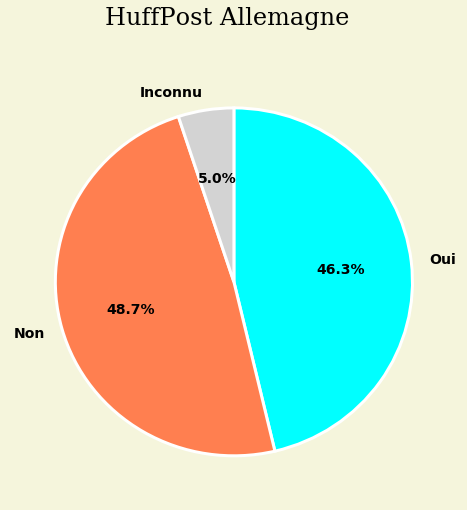

In [17]:
camembert = pd.Series([HP_oui,HP_non,HP_inconnu], index=["Oui","Non","Inconnu"],name="")
titre = plt.figure(facecolor="beige")
titre.suptitle("HuffPost Allemagne", fontsize=24, fontweight="light", fontname="Serif")
camembert.plot.pie(colors=["aqua","coral","lightgrey"],
                   wedgeprops={"linewidth":3,"edgecolor":"white"},
                   textprops={"weight":"bold","fontsize":14},
                   counterclock=False,
                   startangle=90,
                   autopct="%1.1f%%",
                   figsize=(8,8)
)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 6 - Exercice boni&nbsp;: les étiquettes (<i>tags</i>)</h3>

Chaque article du *Huffington Post* est généralement accompagné d'une dizaine de marqueurs, ou d'étiquettes (*tags* en anglais). Voici ceux qui sont le plus fréquemment utilisés par cette édition.

In [18]:
etiquettes = huff.set_index('pays').tags.str.split(',', expand=True).stack().rename(columns={0:'tag'}).reset_index(drop=True)
etiquettes.value_counts(dropna=False)

video                                                      22506
politik                                                    18863
nachrichten                                                17853
entertainment                                              10927
lifestyle                                                  9483 
wirtschaft                                                 6767 
Flüchtlinge                                                2788 
sport                                                      2134 
deutschland                                                2027 
gesundheit                                                 1962 
usa                                                        1810 
technologie                                                1634 
Angela Merkel                                              1565 
russland                                                   1561 
international                                              1432 
kinder                   